In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import io, color
from sklearn.cluster import KMeans

In [50]:
import matplotlib.pyplot as plt

def show_image(image, title='Image'):
    """
    Функция для отображения изображения, поддерживающая как цветные, так и grayscale изображения.
    """
    plt.figure(figsize=(6, 6))
    
    if len(image.shape) == 2:  # Если только один канал
        plt.imshow(image, cmap='gray')  # Отображаем с использованием цветовой карты gray
    else:
        plt.imshow(image)  # Для цветных изображений
    
    plt.title(title)
    plt.axis('off')
    plt.show()

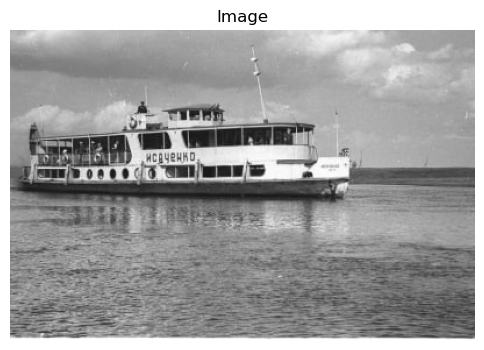

In [457]:
image = io.imread('teplo.jpg')
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
show_image(image)

In [391]:
def method_1(image):
    # Преобразуем изображение в grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применяем оператор Собеля для выделения границ
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    grad_x *= 1.2
    grad_y *= 1.6
    
    grad = cv2.magnitude(grad_x, grad_y)  # Комбинированный градиент
    grad = cv2.convertScaleAbs(grad)  # Преобразуем результат в 8-битное изображение
    show_image(grad, "Gradient Image")
    
    # Усиливаем контраст после градиента
    contrast_grad = cv2.convertScaleAbs(grad, alpha=1.5, beta=20)  # alpha увеличивает контраст, beta смещает яркость
    show_image(contrast_grad, "Enhanced Gradient Image")
    
    # # Применяем Gaussian blur для размытия
    # blurred = cv2.GaussianBlur(contrast_grad, (5, 5), 0)  # (5, 5) — размер ядра, 0 — стандартное отклонение
    # show_image(blurred, "Blurred Image")

    # Применяем минимальный фильтр (Erosion)
    min_filtered = cv2.erode(contrast_grad, np.ones((2, 1), np.uint8), iterations=1)
    show_image(min_filtered, "Min Filtered Image")

    # Бинаризация с использованием метода Оцу для более точной пороговой обработки
    _, thresh = cv2.threshold(min_filtered, 0, 100, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    show_image(thresh, "Threshold Image")

    # Применяем медианный фильтр
    median_blurred = cv2.medianBlur(thresh, 7)9
    show_image(median_blurred, "Median Blurred Image")

    # Поиск контуров
    contours, hierarchy = cv2.findContours(median_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Выбираем самый длинный контур
    longest_contour = max(contours, key=lambda c: cv2.arcLength(c, True))

    # Рисуем только самый длинный контур белым цветом
    contour_image = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, [longest_contour], -1, (255, 255, 255), 2)  # Белый цвет
    show_image(contour_image, "Longest Contour in White")

    return contour_image


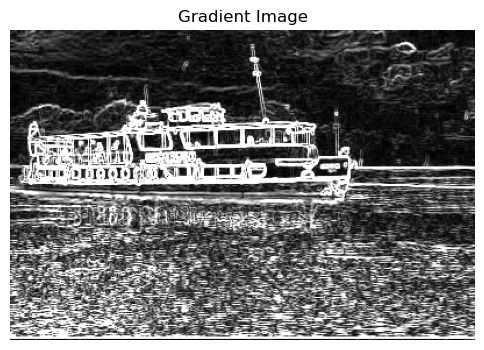

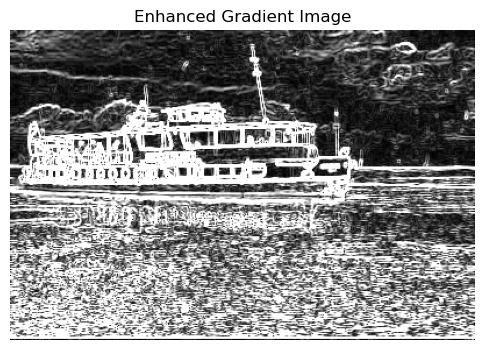

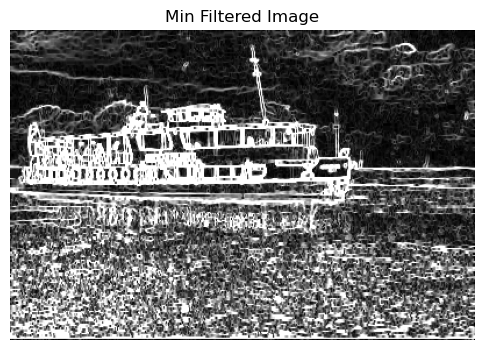

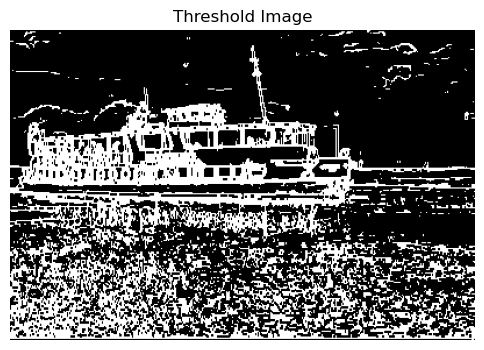

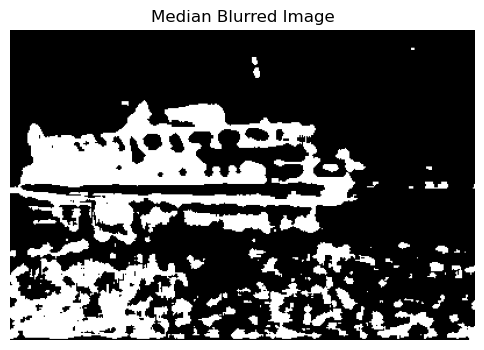

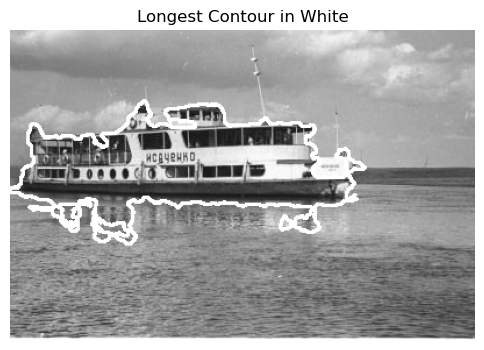

In [392]:
image_1 = method_1(image)

In [557]:
import alphashape
from shapely.geometry import MultiPolygon

def method_2(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Преобразуем в оттенки серого
    
    # blur_gray = cv2.GaussianBlur(gray, (5, 5), 0)  
    # show_image(median_blurred, "Gaussian Blurred Image")
    
    median_blurred = cv2.medianBlur(gray, 3)
    show_image(median_blurred, "Median Blurred Image")
    
    # Canny edge detector
    low_threshold = 100
    high_threshold = 200
    edges = cv2.Canny(median_blurred, low_threshold, high_threshold)
    show_image(edges, "Canny Edges")
    
    # Создаем маску для области интереса (ROI)
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    imshape = image.shape
    
    b_y = 0.2 * imshape[0]
    k_y = 0.57
    k_x = 0.75
    
    vertices = np.array([[(0, k_y * imshape[0]), (0, b_y + 0), (k_x * imshape[1], b_y + 0), (k_x * imshape[1], k_y*imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    show_image(masked_edges, "Masked Edges")
    
    # 1) Находим контуры на изображении
    contours, _ = cv2.findContours(masked_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Рисуем все контуры на копии изображения
    coutoured_image = np.copy(image)
    cv2.drawContours(coutoured_image, contours, -1, (255, 0, 0), 2)  # Синий цвет, толщина 2    
    show_image(coutoured_image, "Contours")
    
    # 2) Создаем копию изображения для рисования контуров и выпуклой оболочки
    hulled_image = np.copy(image)
    
    # Объединяем все контуры в один массив точек
    all_points = np.concatenate(contours)
    
    # Преобразуем массив точек в формат, подходящий для alphashape
    points = [tuple(point[0]) for point in all_points]
    
    # Используем alphashape для нахождения выпуклой оболочки
    alpha_shape = alphashape.alphashape(points, alpha=0.1) # 0.5 - 1.0
    
    # Если результат - это MultiPolygon, обрабатываем каждый полигон
    if isinstance(alpha_shape, MultiPolygon):
        for polygon in alpha_shape.geoms:
            convex_hull_points = np.array(list(polygon.exterior.coords), dtype=np.int32)

            # Рисуем выпуклую оболочку (concave hull) красным цветом
            cv2.polylines(hulled_image, [convex_hull_points], isClosed=True, color=(0, 0, 255), thickness=2)  # Красный цвет

    else:
        # В случае, если получен один полигон, рисуем его
        convex_hull_points = np.array(list(alpha_shape.exterior.coords), dtype=np.int32)
        cv2.polylines(hulled_image, [convex_hull_points], isClosed=True, color=(0, 0, 255), thickness=2)  # Красный цвет
    
    show_image(hulled_image)
    
    return hulled_image

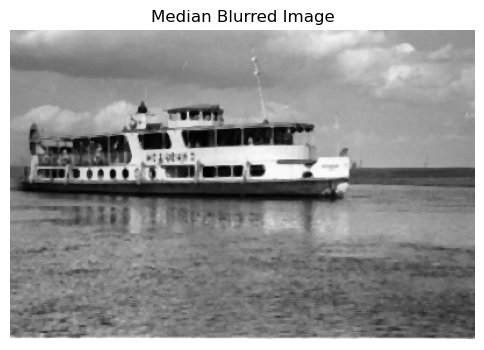

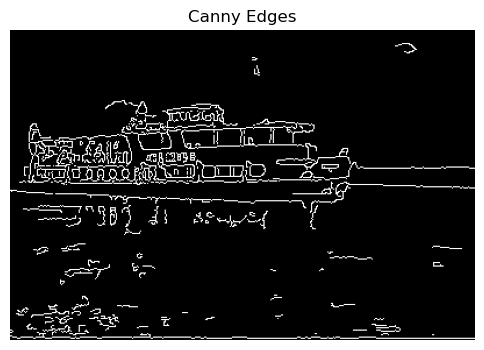

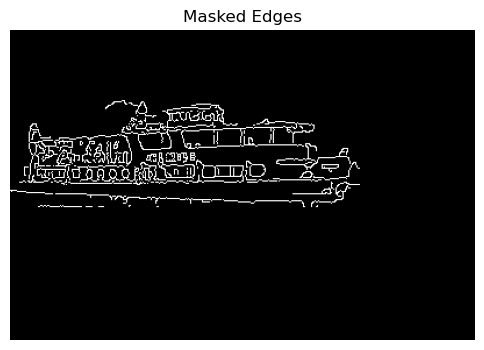

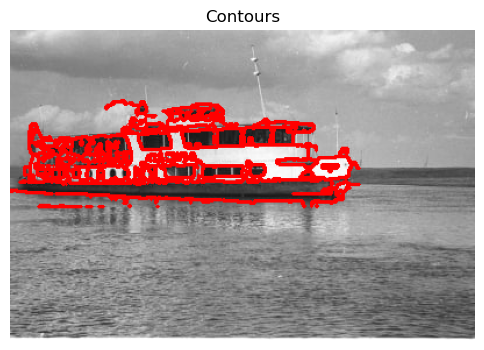

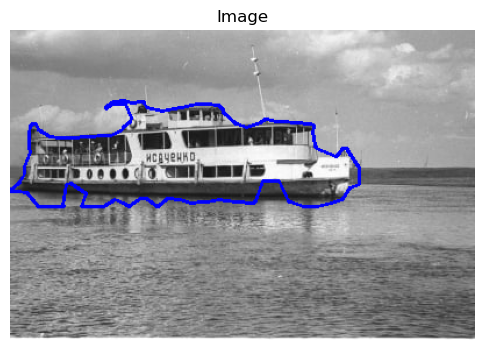

In [558]:
image2 = method_2(image)